In [1]:
!pip install pandas xgboost hdbscan matplotlib seaborn


In [3]:
import json
import pandas as pd
import numpy as np

# Load JSON file
with open('/content/user-wallet-transactions.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Inspect structure
print(df.head())


                                    _id  \
0  {'$oid': '681d38fed63812d4655f571a'}   
1  {'$oid': '681aa70dd6df53021cc6f3c0'}   
2  {'$oid': '681d04c2d63812d4654c733e'}   
3  {'$oid': '681d133bd63812d46551b6ef'}   
4  {'$oid': '681899e4ba49fc91cf2f4454'}   

                                   userWallet  network protocol  \
0  0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1  0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3  0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4  0x0000000000e189dd664b9ab08a33c4839953852c  polygon  aave_v2   

                                              txHash  \
0  0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...   
1  0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...   
2  0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...   
3  0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...   
4  0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...   

 

In [5]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['day'] = df['timestamp'].dt.date

# Basic features per wallet
features = df.groupby('userWallet').agg({
    'action': ['count', lambda x: (x == 'deposit').sum(), lambda x: (x == 'borrow').sum(),
               lambda x: (x == 'repay').sum(), lambda x: (x == 'liquidationcall').sum()],
    'timestamp': ['min', 'max'],
    'day': pd.Series.nunique
})

features.columns = ['total_txns', 'deposits', 'borrows', 'repays', 'liquidations',
                    'first_seen', 'last_seen', 'active_days']

# Time active
features['days_active'] = (features['last_seen'] - features['first_seen']).dt.days + 1
features['txns_per_day'] = features['total_txns'] / features['days_active']
features['deposit_ratio'] = features['deposits'] / features['total_txns']
features['borrow_ratio'] = features['borrows'] / features['total_txns']
features['repay_ratio'] = features['repays'] / features['total_txns']
features['liq_ratio'] = features['liquidations'] / features['total_txns']
features.reset_index(inplace=True)

features.fillna(0, inplace=True)

In [6]:
# Mark wallet as bot if txns_per_day is too high (tweakable)
features['is_bot'] = features['txns_per_day'] > 50


In [7]:
from sklearn.preprocessing import StandardScaler
import hdbscan

clustering_features = ['txns_per_day', 'deposit_ratio', 'borrow_ratio', 'repay_ratio', 'liq_ratio']
X = StandardScaler().fit_transform(features[clustering_features])

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
features['cluster'] = clusterer.fit_predict(X)

# Optional: consider cluster with high bot ratio as bot
bot_clusters = features.groupby('cluster')['is_bot'].mean()
sus_clusters = bot_clusters[bot_clusters > 0.7].index
features['hdbscan_bot'] = features['cluster'].isin(sus_clusters)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Use if labeled
if 'label' in features.columns:
    X = features[clustering_features]
    y = features['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    # Predict probabilities, convert to 0-1000 scale
    features['xgb_score'] = model.predict_proba(X)[:, 1]
    features['credit_score'] = (features['xgb_score'] * 1000).astype(int)
else:
    # Unsupervised fallback score
    features['credit_score'] = (
        500 * (1 - features['liq_ratio']) +
        300 * features['repay_ratio'] +
        200 * features['deposit_ratio'] -
        100 * features['is_bot'].astype(int)
    ).astype(int)
    features['credit_score'] = features['credit_score'].clip(0, 1000)


/tmp/ipython-input-9-1438365305.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=features, x='score_bucket', palette='coolwarm')


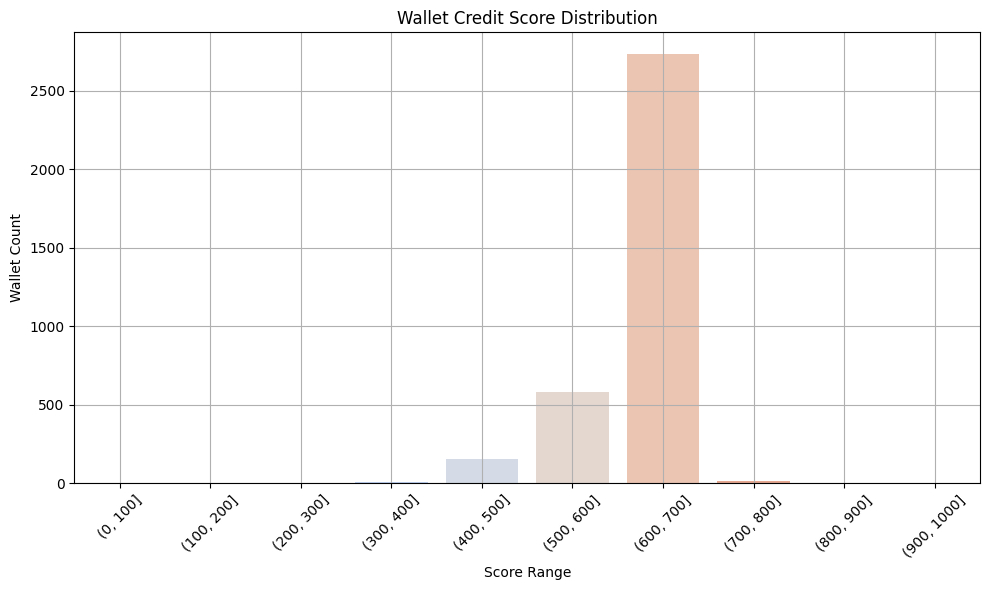

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

bins = list(range(0, 1100, 100))
features['score_bucket'] = pd.cut(features['credit_score'], bins)

plt.figure(figsize=(10, 6))
sns.countplot(data=features, x='score_bucket', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Score Range")
plt.ylabel("Wallet Count")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
with open("analysis.md", "w") as f:
    f.write("# Wallet Score Analysis\n\n")
    f.write("## Score Distribution\n")
    dist = features['score_bucket'].value_counts().sort_index()
    f.write(dist.to_markdown())
    f.write("\n\n")

    f.write("## Behavior of Wallets (Low Score)\n")
    low = features[features['credit_score'] < 300].describe()
    f.write(low.to_markdown())
    f.write("\n\n")

    f.write("## Behavior of Wallets (High Score)\n")
    high = features[features['credit_score'] > 700].describe()
    f.write(high.to_markdown())


In [12]:
features[['userWallet', 'credit_score']].to_csv("wallet_scores.csv", index=False)